In [1]:
import os
import json
import tqdm
import shutil

In [2]:
meta_path = '/data/PanoHeadData/single_view_hq/dataset.json'
with open(meta_path, 'r') as f:
    meta = json.load(f)
print(len(meta.keys()))

404524


In [3]:
data_sources = {}
for image_name, image_meta in tqdm.tqdm(meta.items()):
    data_source = image_meta['data_source']
    if data_source not in data_sources.keys():
        data_sources[data_source] = 0
    data_sources[data_source] += 1

  0%|          | 0/404524 [00:00<?, ?it/s]

100%|██████████| 404524/404524 [00:00<00:00, 1504553.16it/s]


In [4]:
data_sources

{'FFHQ': 68744,
 'CelebA': 25754,
 'LPFF': 15439,
 'Web': 25780,
 'K-Hairstyle/Validation': 11931,
 'K-Hairstyle/Training': 109816,
 'OCD/Brown Black': 12330,
 'OCD/Charcoal': 12330,
 'OCD/Dark Reddish Brown': 12540,
 'OCD/Espresso': 12660,
 'OCD/Original': 24510,
 'OCD/Wine': 12690,
 'OCD/Dark Maroon': 11610,
 'OCD/Sable': 12330,
 'OCD/Darkest Brown': 11850,
 'OCD/Chestnut': 11790,
 'OCD/Jet': 12420}

In [5]:
# sample_num = 10
# sample_image_names = []
sample_image = None
for image_name, image_meta in tqdm.tqdm(meta.items()):
    data_source = image_meta['data_source']
    if data_source == 'OCD/Original':
        sample_image = image_name
        break
print(sample_image)
#         sample_image_names.append(image_name)
#     if len(sample_image_names) >= sample_num:
#         break
# print(sample_image_names)

 64%|██████▎   | 257584/404524 [00:00<00:00, 2006659.74it/s]

00257/img00257626.png


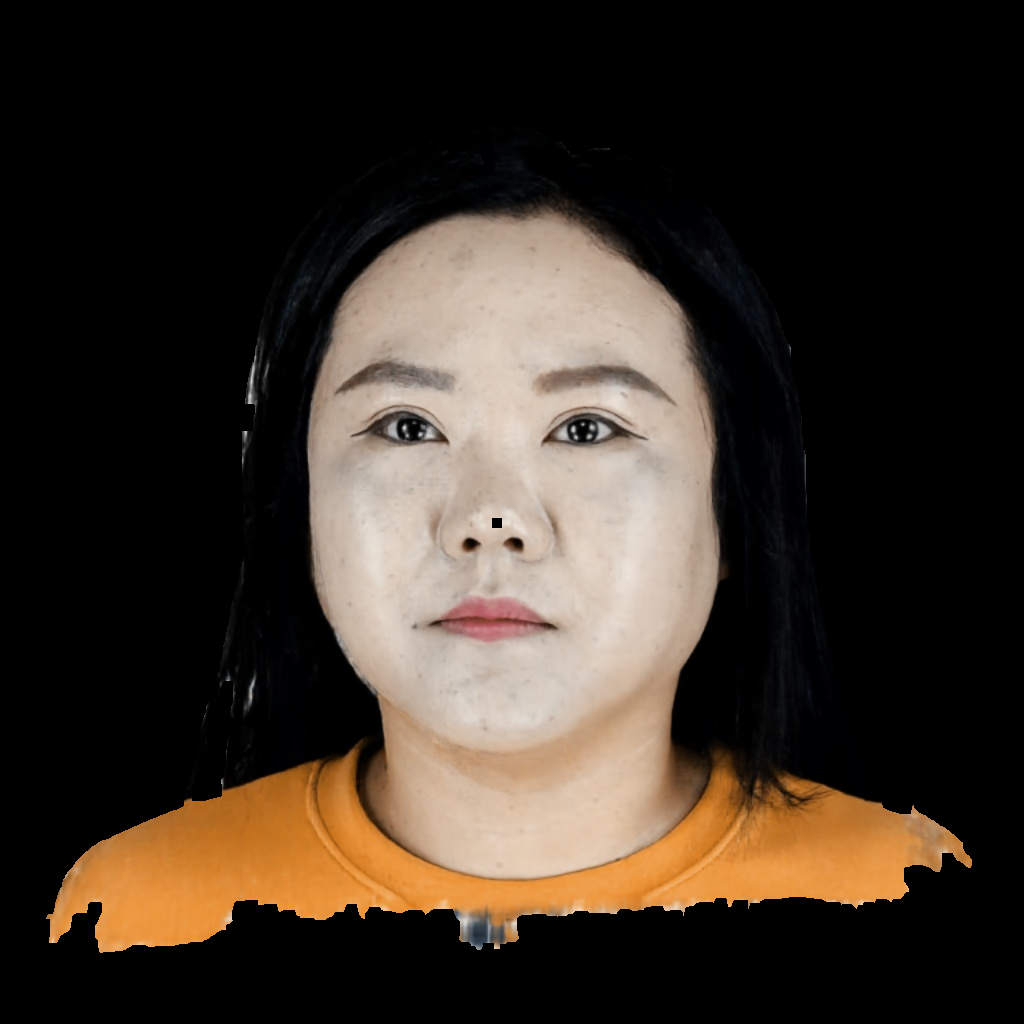

In [6]:
from IPython import display
from PIL import Image
import cv2
import numpy as np

image_data = cv2.imread(os.path.join('/data/PanoHeadData/single_view_hq', 'head_images', sample_image.replace('png', 'jpg')))
image_bivalue = cv2.cvtColor(image_data, cv2.COLOR_BGR2GRAY)
image_bivalue = cv2.threshold(image_bivalue, 229, 255, cv2.THRESH_BINARY)[1]


# erode the edge
kernel = np.ones((10,10),np.uint8)
image_bivalue = cv2.dilate(image_bivalue, kernel, iterations = 1)
# get the maximum connected component
_, labels, stats, _ = cv2.connectedComponentsWithStats((255 - image_bivalue))
max_label = 0
max_area = 0
for i in range(1, len(stats)):
    if stats[i][4] > max_area:
        max_area = stats[i][4]
        max_label = i
# display the maximum connected component mask
max_component = np.zeros_like(image_bivalue)
max_component[labels == max_label] = 255
# apply the mask to the original image
image_data[max_component == 0] = 0
display.display(Image.fromarray(cv2.cvtColor(image_data, cv2.COLOR_BGR2RGB)))

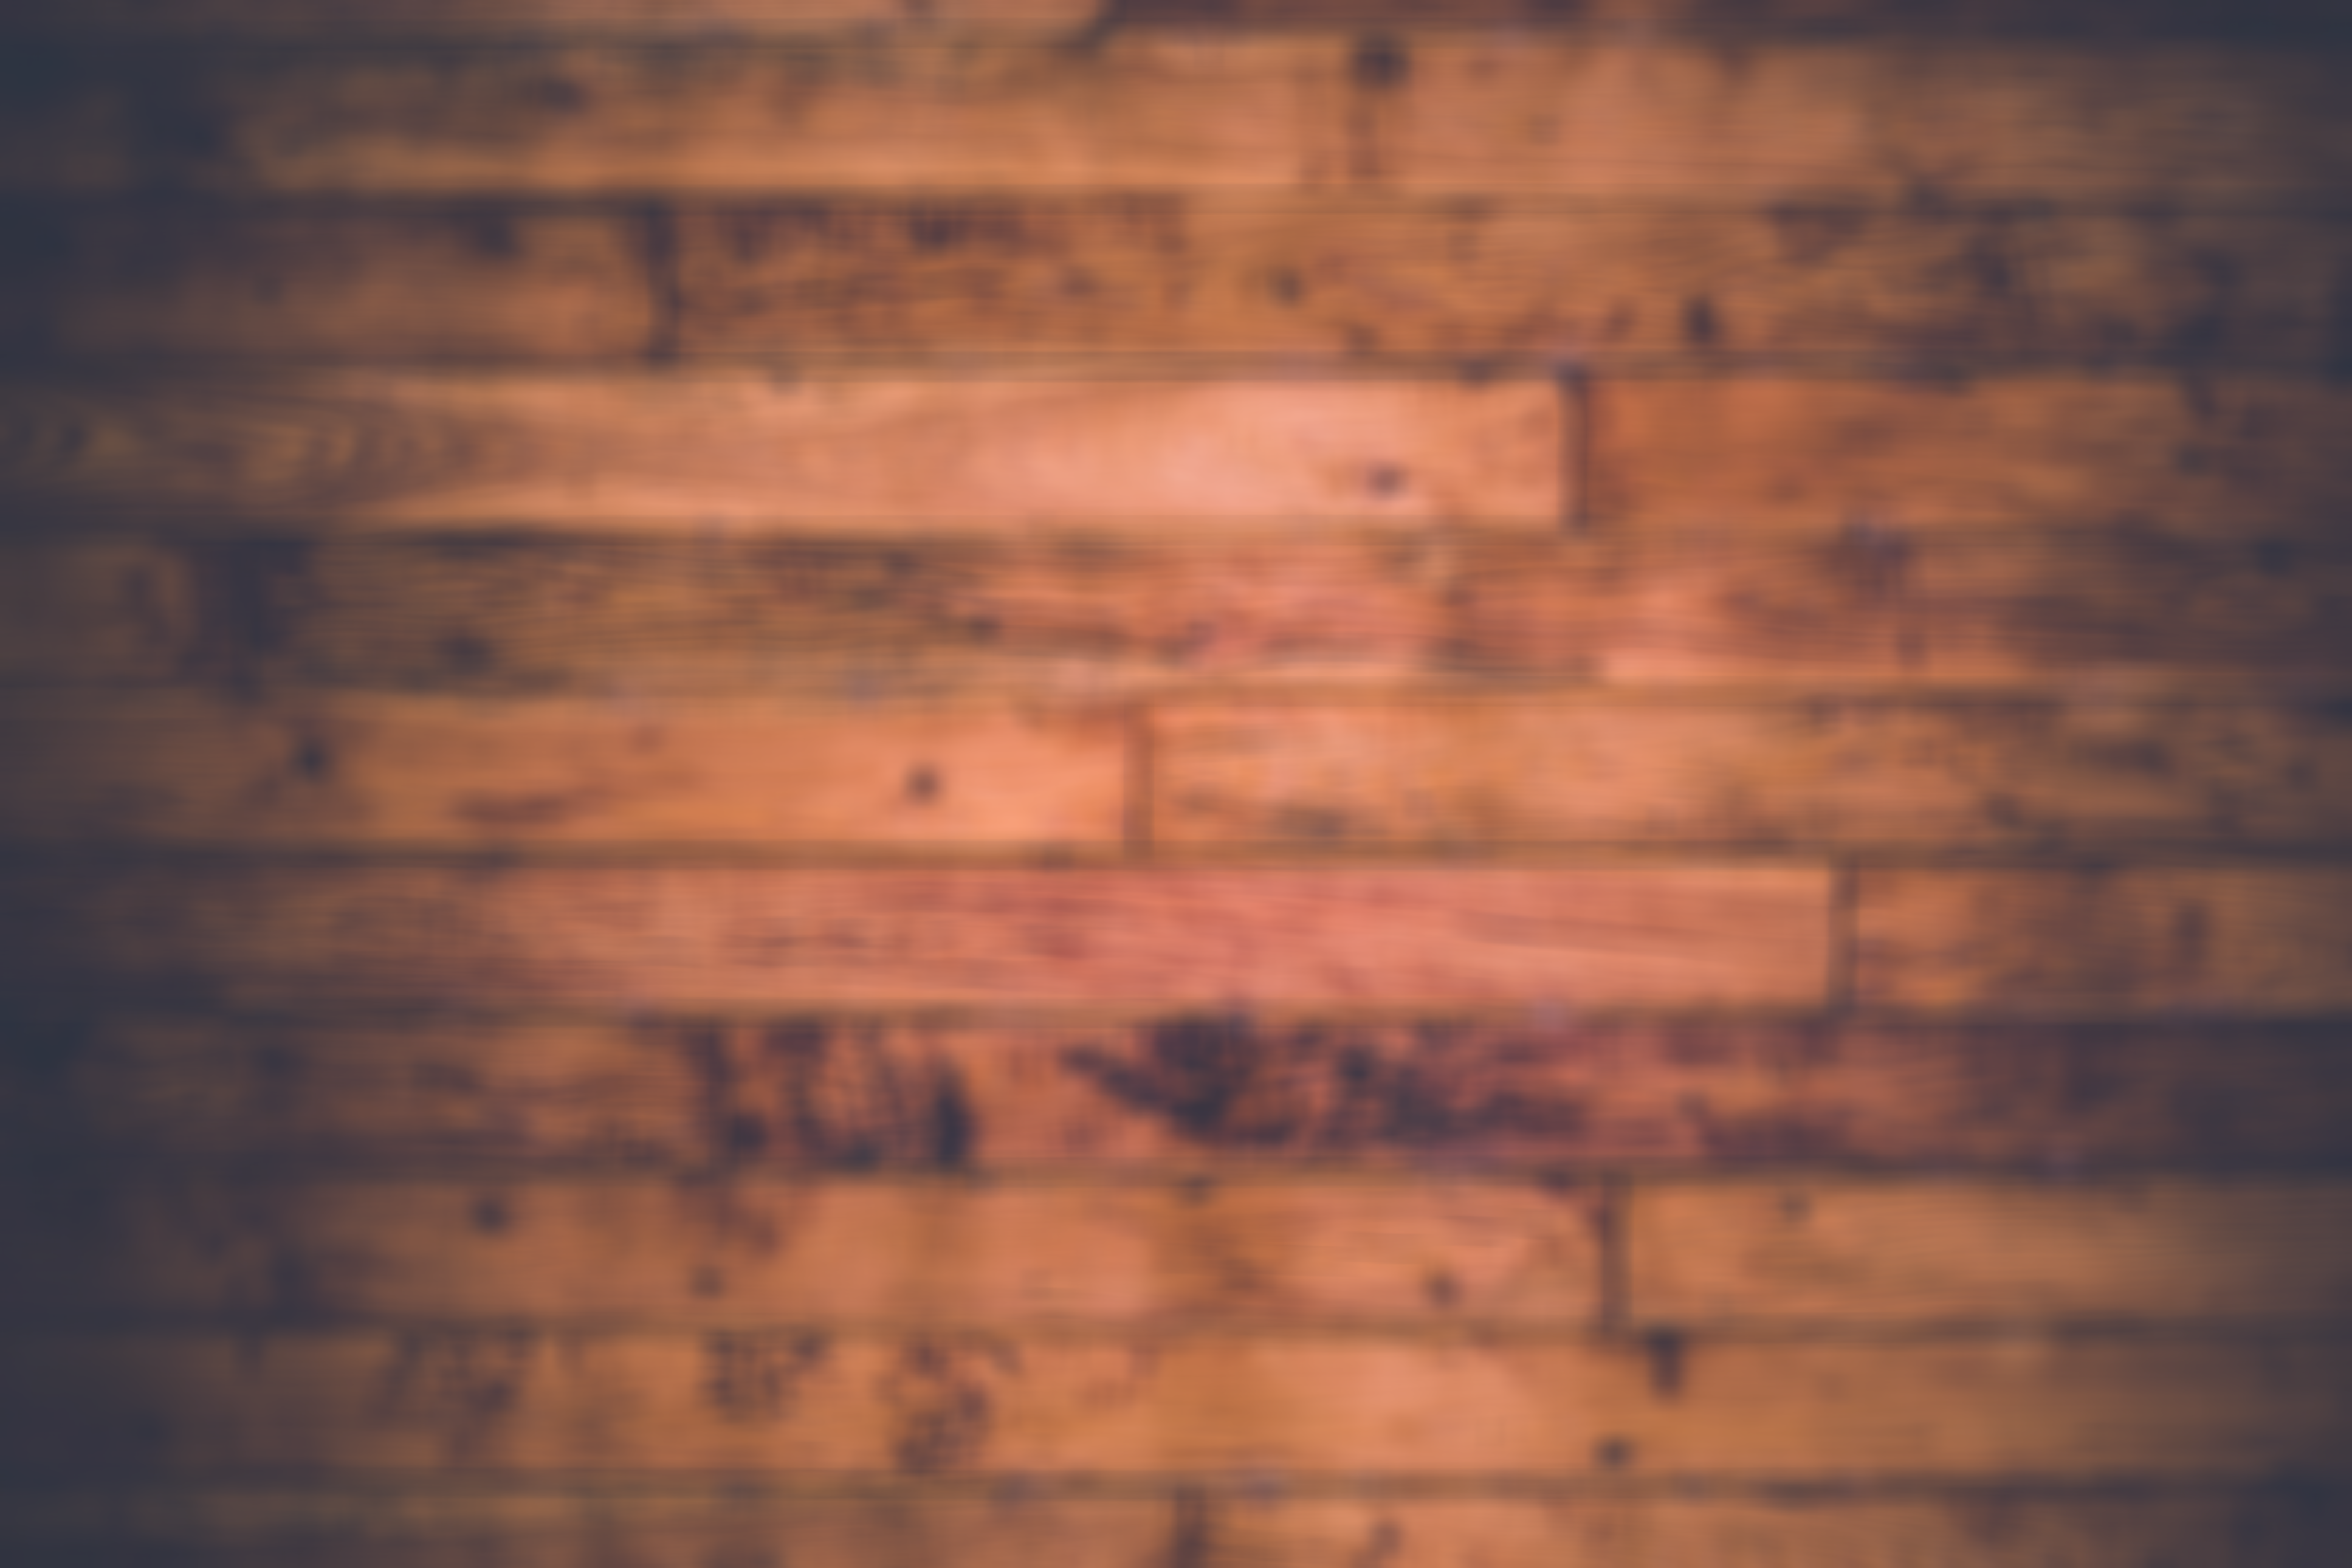

In [11]:
bg_image_path = '/home/tianhao/DatProc/temp/bg_test.jpg'
bg_data = cv2.imread(bg_image_path)
# blur
bg_data = cv2.blur(bg_data, (50, 50))
display.display(Image.fromarray(cv2.cvtColor(bg_data, cv2.COLOR_BGR2RGB)))

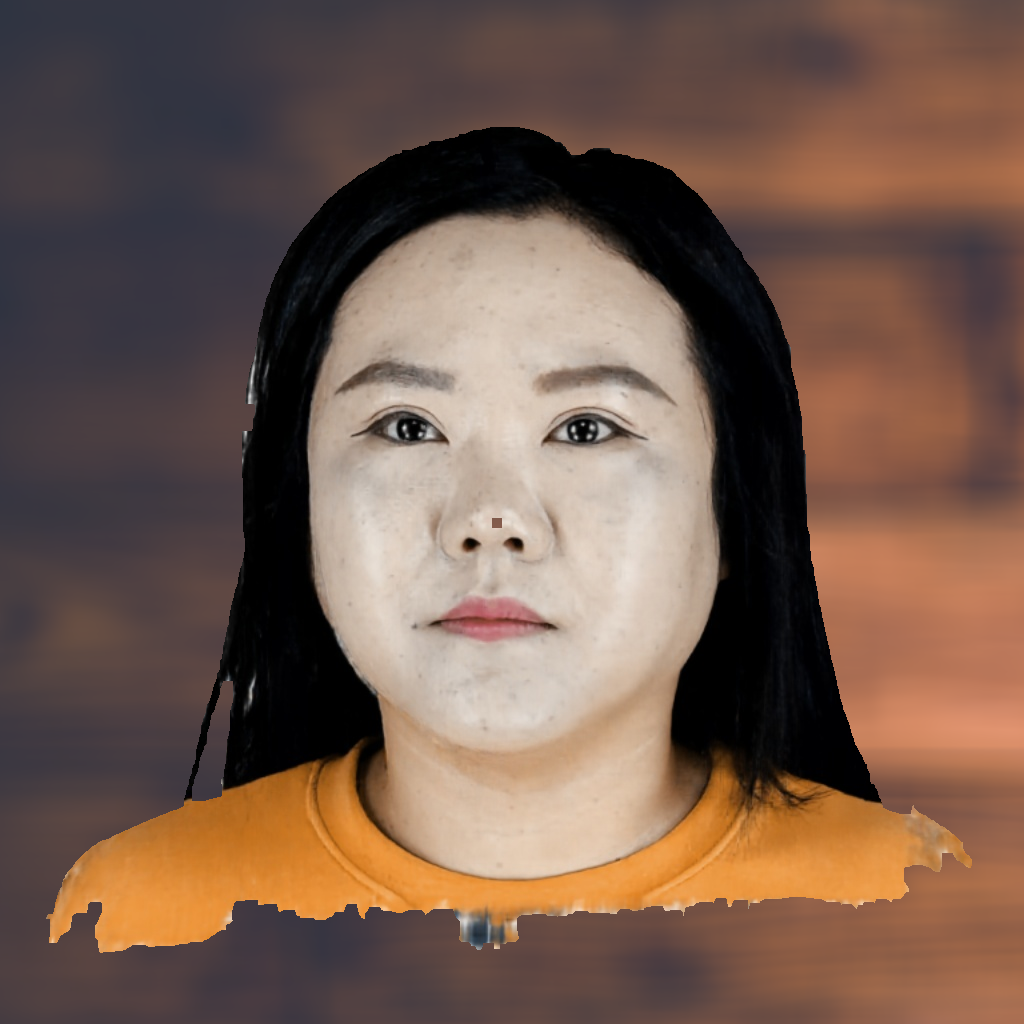

In [12]:
put_loc = (100, 100)
background_crop = bg_data[put_loc[0]:put_loc[0]+image_data.shape[0], put_loc[1]:put_loc[1]+image_data.shape[1]]

# put the image on the background. If mask is 0, use color value in background; else, show the image.
# mask = cv2.cvtColor(max_component, cv2.COLOR_GRAY2BGR)
output = np.zeros_like(image_data)
for row in range(image_data.shape[0]):
    for col in range(image_data.shape[1]):
        if max_component[row, col] == 0:
            output[row, col] = background_crop[row, col]
        else:
            output[row, col] = image_data[row, col]
display.display(Image.fromarray(cv2.cvtColor(output, cv2.COLOR_BGR2RGB)))
# display.display(Image.fromarray(cv2.cvtColor(bg_data, cv2.COLOR_BGR2RGB)))

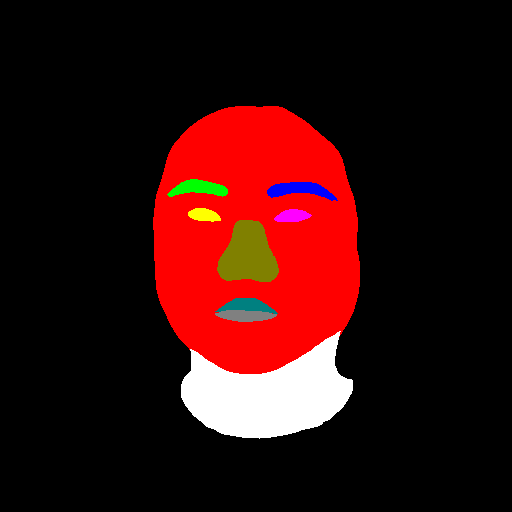

In [49]:
import numpy as np
parsing_data = cv2.imread(os.path.join('/data/PanoHeadData/single_view_hq', 'head_parsing', sample_image), cv2.IMREAD_GRAYSCALE)
# define the color map for each class
color_map = {
    0: (0, 0, 0),    # background
    1: (255, 0, 0),  # hair
    2: (0, 255, 0),  # face
    3: (0, 0, 255),  # upper clothes
    4: (255, 255, 0),# pants
    5: (255, 0, 255),# dress
    6: (0, 255, 255),# coat
    7: (128, 0, 0),  # socks
    8: (0, 128, 0),  # shoes
    9: (0, 0, 128),  # hat
    10: (128, 128, 0),# glove
    11: (128, 0, 128),# scarf
    12: (0, 128, 128),# glasses
    13: (128, 128, 128),# bag
    14: (255, 255, 255),# background
}

# apply the color map to the semantic segmentation map
color_map_data = np.zeros((parsing_data.shape[0], parsing_data.shape[1], 3), dtype=np.uint8)
for class_id, color in color_map.items():
    color_map_data[parsing_data == class_id] = color
height = 512
width = int(color_map_data.shape[1] * height / color_map_data.shape[0])
resized_color_map = cv2.resize(color_map_data, (width, height))
# display the color map data
display.display(Image.fromarray(resized_color_map))
